# Klasteryzacja

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo:
- Plotly - do wizualizacji
- UMAP, HDBSCAN - implementacja algorytmów

**Uwaga:** upewnij się, że masz scikit-learn w wersji 1.2 lub nowszej (druga komórka poniżej). Dzięki temu będzie można ustawić opcję `transform_output="pandas"`, dzięki której wszystkie transformatory w scikit-learn będą nie tylko przyjmować, ale też zwracać DataFrame, zachowując nazwy zmiennych. Będzie to bardzo przydatne w analizie danych.

In [2]:
!pip install numpy scipy pandas matplotlib scikit-learn missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install plotly umap-learn hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza muzyki ze Spotify

Spotify w swoim API oferuje automatyczną [ekstrakcję cech z piosenek](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), których można następnie użyć do wielu ciekawych analiz, jak np. [tutaj](https://rpubs.com/PeterDola/SpotifyTracks) lub [tutaj](https://rstudio-pubs-static.s3.amazonaws.com/604869_8399a2cf0e4a419da6272452c3d6a6d3.html). Datasetów jest wiele, z czego jednym z największych [jest dostępny tutaj na Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) i zawiera ponad 600 tysięcy piosenek.

Cechy zwracane przez API to m. in. akustyczność, taneczność, energia, głośność czy długość piosenki. Pełna lista cech jest dostępna [w dokumentacji](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Są to bardzo dobre cechy do uczenia maszynowego - niewielka wymiarowość i tylko numeryczne. Wadą jest pewna dość mocna korelacja w niektórych podgatunkach muzycznych, ale akurat to w przypadku klasteryzacji takich danych jest całkiem ok, i może prowadzić do sensownych wniosków.

Spotify definiuje i wykorzystuje ponad 125 gatunków muzycznych, które na dodatek są dość dyskusyjne i płynne. Przykładowo, według różnych klasyfikacji Powerwolf, Ensiferum i Alestorm mogą wylądować w tym samym worku, pomimo zdecydowanie różnej muzyki. Klasteryzacja pozwala tworzyć "płynne" tagi, klasyfikując muzykę w dużo bardziej zniuansowany sposób.

**Uwaga:** zgodnie z licencją API danych nie można używać do treningu modeli ML. Oczywiście tego typu licencje nie dotyczą użytku prywatnego ani zastosowań naukowych, co wynika z ogólnych przepisów. Należy jednak pamiętać, że takich modeli nie wolno w żaden sposób publikować ani wykorzystywać komercyjnie.

**Zadanie 1 (2.5 punktu)**

1. Ściągnij pliki `artists.csv` oraz `tracks.csv` z Kaggle'a.
2. Załaduj pliki do zmiennych `df_artists` i `df_tracks`.
3. Usuń wiersze z wartościami brakującymi z obu ramek danych.
4. Ponad 600 tysięcy piosenek to zdecydowanie za dużo, a na dodatek przeważająca większość z nich to drobni, mało znani artyści. Aby to zweryfikować, narysuj histogramy popularności artystów oraz piosenek. Użyj 100 kubełków (bins). Pamiętaj o tytułach wykresów.
5. Pozostaw tylko artystów z popularnością minimum 55, oraz tylko piosenki z popularnością minimum 45.
6. Większość piosenek trwa kilka minut, ale są anomalie, które trwają bardzo długo. Pozostaw tylko te piosenki, które trwają co najwyżej 600.000 ms (10 minut).
7. Użyj podanej funkcji `extract_artist_id()` na ramce z piosenkami, która dodaje kolumnę `main_artist_id`.
8. Połącz ramki w jedną, `df_songs`, z wszystkimi informacjami:
   - użyj kolumn `main_artist_id` (ramka z piosenkami) oraz `id` (ramka z artystami)
   - przyda się `pd.merge()`
   - Pandas automatycznie dodaje sufiksy do kolumn (argument `suffixes`), żeby rozróżnić kolumny po takiej operacji JOIN
   - domyślnie są to mało znaczące `_x` i `_y`, zmień je na `_track` i `_artist`
9. Usuń duplikaty wedle kolumn `name_track` oraz `name_artist`.
10. Mamy kolumny z danymi, które identyfikują piosenki: nazwa piosenki, artysta, gatunki muzyczne. Nie są one jednak użyteczne do samej klasteryzacji. Wyodrębnij je do osobnej ramki `df_songs_info`.
```
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]
```
11. Stwórz nową ramkę `df_songs_features`, pozostawiając tylko kolumny z cechami do klasteryzacji:
```
songs_features_cols = [
    "duration_ms",
    "explicit",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
]
```
12. Wypisz finalną liczbę piosenek (rozmiar zbioru).

In [7]:
import ast


def extract_artist_id(df_tracks: pd.DataFrame) -> pd.DataFrame:
    df_tracks["main_artist_id"] = df_tracks["id_artists"].apply(
        lambda x: ast.literal_eval(x)[0]
    )
    return df_tracks

In [8]:
df_artists = pd.read_csv("artists.csv")
df_tracks = pd.read_csv("tracks.csv")

In [9]:
df_artists.dropna(inplace=True)
df_tracks.dropna(inplace=True)

<Axes: ylabel='Frequency'>

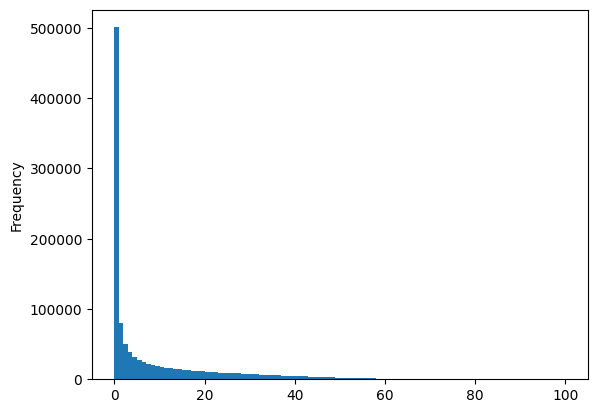

In [10]:
df_artists["popularity"].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

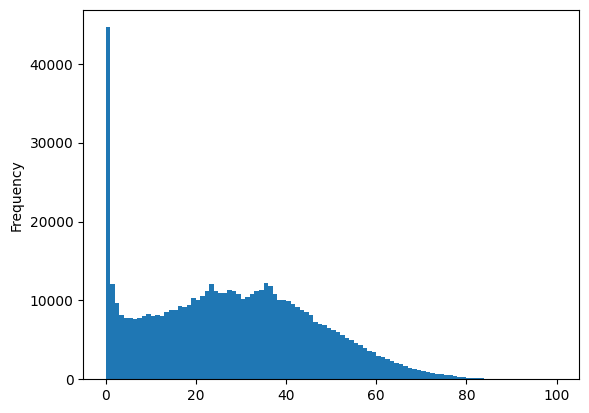

In [11]:
df_tracks["popularity"].plot.hist(bins=100)

In [12]:
df_artists = df_artists[df_artists["popularity"] > 55]
df_tracks = df_tracks[df_tracks["popularity"] > 45]

In [13]:
df_tracks = df_tracks[df_tracks["duration_ms"] < 600000]

In [14]:
df_tracks = extract_artist_id(df_tracks)

In [15]:
df_songs = pd.merge(
    df_tracks,
    df_artists,
    left_on=df_tracks["main_artist_id"],
    right_on=df_artists["id"],
    suffixes=("_track", "_artist"),
)

In [16]:
df_songs.drop_duplicates(["name_track", "name_artist"], inplace=True)

In [17]:
songs_info_cols = ["name_track", "name_artist", "genres"]
df_songs_info = df_songs[songs_info_cols]

In [18]:
songs_features_cols = [
    "duration_ms",
    "explicit",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
]

df_songs_features = df_songs[songs_features_cols]

In [19]:
df_songs.shape[0]

69826

Mamy teraz przygotowane dane, więc można brać się za klasteryzację. Nasz zbiór jest dość duży, nawet po dokonanym ostrym filtrowaniu, więc potrzebujemy skalowalnych algorytmów klasteryzacji. Klasteryzacja hierarchiczna zdecydowanie odpada, pozostają więc k-means, DBSCAN i HDBSCAN. Co prawda hiperparametry do DBSCAN ciężko jest dobrać, ale zobaczymy, jak można to zrobić.

Zanim przejdziemy do klasteryzacji, trzeba ustandardyzować nasze dane. Po tym trzeba przeprowadzić też globalną analizę naszego zbioru, jak na przykład rozkłady cech, albo zwizualizować go z pomocą redukcji wymiaru. Jest to ważne, bo przy późniejszej analizie klastrów musimy wiedzieć, czy klastry w ogóle różnią się od ogółu naszych danych.

**Zadanie 2 (1 punkt)**

1. Dokonaj standaryzacji cech, tworząc ramkę `X`.
2. Uzupełnij kod klasy `ClusteringVisualizer`, która przyjmuje dane, numery klastrów dla poszczególnych punktów (opcjonalne), i przedstawia wykresy PCA oraz UMAP:
   - zredukuj dane do 2 wymiarów
   - pamiętaj o `random_state=0`
   - [dokumentacja UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - przekaż `low_memory=False` dla UMAP
   - ze względu na specyfikę implementacji, wykorzystanie `.fit_transform()` będzie zauważalnie szybsze od osobnych `.fit()` i `.transform()`
   - skomentuj:
     - czy w przypadkU PCA widać jakąś strukurę klastrów?
     - czy widać ją w przypadku UMAP?
     - czy redukcja nieliniowa dała lepsze, czy gorsze wyniki od liniowego PCA w wizualizacji?

Czemu klasa, a nie funkcja? UMAP, jak praktycznie wszystkie metody nieliniowej redukcji wymiaru, wykorzystuje graf najbliższych sąsiadów. Jeżeli obliczymy dane po redukcji raz, i zapiszemy jako atrybut, to później będziemy mogli uniknąć liczenia tego wielokrotnie. Zapisanie tych wyników zaoszczędzi nam wiele minut :)

In [20]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X = scaler.fit_transform(df_songs_features)

In [21]:
from typing import Optional

from IPython.display import display
from sklearn.decomposition import PCA
from umap.umap_ import UMAP


class ClusteringVisualizer:
    def __init__(self, X: np.ndarray | pd.DataFrame):
        # perform PCA and UMAP
        # save results as Numpy arrays
        self.X_2d_pca = PCA(2, random_state=0).fit_transform(X).to_numpy()
        self.X_2d_umap = UMAP(low_memory=False, random_state=0).fit_transform(X)

    def visualize(self, labels: Optional[np.ndarray] = None):
        if labels is None:
            labels = np.ones(len(X))

        fig, axes = plt.subplots(1, 2, figsize=(9, 3))

        axes[0].scatter(self.X_2d_pca[:, 0], self.X_2d_pca[:, 1], c=labels)
        axes[1].scatter(self.X_2d_umap[:, 0], self.X_2d_umap[:, 1], c=labels)

        axes[0].title.set_text("PCA")
        axes[1].title.set_text("UMAP")

        fig.suptitle("Clustering visualization")
        plt.show()

In [22]:
clustering_visualizer = ClusteringVisualizer(X)

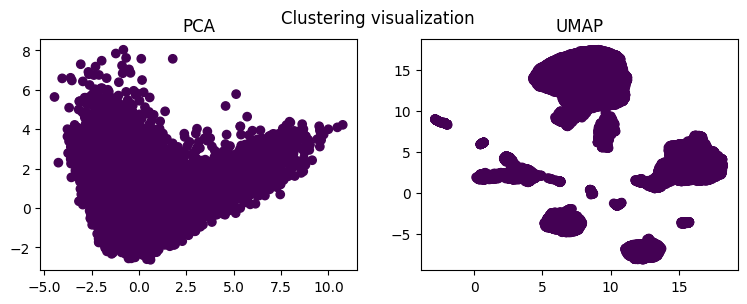

In [23]:
clustering_visualizer.visualize()

// skomentuj tutaj

Teraz przeanalizujemy nasz zbiór. Posłużą nam do tego poniżej zdefiniowane klasy `KMeansAnalzyer`, `DBSCANAnalyzer` i `HDBSCANAnalyzer`. Metoda `.analyze_clustering()` dla każdego klastra:
1. Wypisuje liczbę klastrów, oraz informację o szumie (dla DBSCAN i HDBSCAN).
2. Wypisuje wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), jeżeli liczba klastrów to co najmniej 2. Dla DBSCAN i HDBSCAN uwzględniamy tylko punkty z klastrów, ignorując szum.
2. Rysuje wykres klastrów po redukcji z PCA oraz UMAP.
3. Tworzy [wykres radowy (radar chart)](https://plotly.com/python/radar-chart/). Pozwala on wygodnie porównać wartości średnie dla poszczególnych cech.
4. Wypisuje piosenki i artystów reprezentujące klaster:
   - dla k-means jest to 10 punktów najbliższych do centroidu
   - dla DBSCAN wybieramy heurystycznie 10 punktów najbliższych do centroidu
   - dla HDBSCAN wybieramy punkty o najwyższym prawdopodobieństwie (nie używamy exemplars, bo jest to bardzo wolne [i mało wygodne](https://github.com/scikit-learn-contrib/hdbscan/issues/304))
5. Wypisuje 10 najczęstszych gatunków muzycznych w klastrze.

Dla DBSCAN i HDBSCAN, które same wykrywają liczbę klastrów i może być ich bardzo dużo, analizowane jest tylko:
- max 10 największych klastrów
- tylko te, które mają co najmniej 100 próbek

Na początek potraktujemy cały nasz zbiór jako jeden wielki klaster dla algorytmu k-means i popatrzymy, co tam się dzieje.

In [24]:
import itertools
from abc import ABC, abstractmethod
from collections import Counter

import plotly.graph_objects as go

from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale


class ClusteringAnalyzer(ABC):
    def __init__(
        self, df_songs_info: pd.DataFrame, clustering_visualizer: ClusteringVisualizer
    ):
        self.df_songs_info = df_songs_info
        self.clustering_visualizer = clustering_visualizer

    @abstractmethod
    def analyze_clustering(self, X: pd.DataFrame, clustering) -> None:
        raise NotImplementedError()

    def _get_top_clusters_labels(self, labels: np.ndarray) -> np.ndarray:
        labels = labels[labels != -1]
        label_counts = pd.Series(labels).value_counts()
        label_counts = label_counts[label_counts >= 100]
        top_labels = label_counts.index[:10].values
        return top_labels

    def _create_radar_chart(self, X: pd.DataFrame, label: int) -> None:
        fig = go.Figure()
        vals = minmax_scale(X).mean()
        fig.add_trace(go.Scatterpolar(r=vals, theta=X.columns, fill="toself"))
        fig.update_layout(title_text=f"Cluster {label}", title_x=0.5)
        fig.update_polars(radialaxis=dict(range=[0, 1]))
        fig.show()

    def _get_central_songs(
        self, X: pd.DataFrame, cluster_songs_info: pd.DataFrame, prototype: np.ndarray
    ) -> None:
        n_neighbors = min(10, len(X))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(X.values)
        _, nn_idxs = nn.kneighbors(prototype)
        nn_idxs = nn_idxs.ravel()
        nn_songs_info = cluster_songs_info.iloc[nn_idxs]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

    def _get_cluster_top_genres(
        self,
        cluster_songs_info: pd.DataFrame,
    ) -> None:
        genres = cluster_songs_info["genres"].values
        genres = [ast.literal_eval(x) for x in genres]
        genres = Counter(itertools.chain(*genres))
        top_genres = genres.most_common(10)
        top_genres = [name for name, count in top_genres]
        print("Top 10 genres in the cluster:", top_genres)


class KMeansAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_
        centroids = clustering.cluster_centers_

        print(f"Number of clusters: {max(labels) + 1}")

        if labels.max() >= 2:
            ch_index = calinski_harabasz_score(X, labels)
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in range(0, max(labels) + 1):
            X_cluster = X[labels == label]
            cluster_songs_info = self.df_songs_info[labels == label]
            centroid = centroids[label].reshape((1, -1))

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)


class DBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = self.df_songs_info[labels == label]
            centroid = self._get_cluster_centroid(X_cluster)

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_cluster_centroid(self, X_cluster: pd.DataFrame) -> np.ndarray:
        centroid = np.mean(X_cluster.values, axis=0)
        return np.array(centroid).reshape((1, -1))


class HDBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: HDBSCAN) -> None:
        labels = clustering.labels_
        probas = clustering.probabilities_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = self.df_songs_info[labels == label]
            cluster_probas = probas[labels == label]

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_most_probable_songs(cluster_songs_info, cluster_probas)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_most_probable_songs(
        self, cluster_songs_info: pd.DataFrame, cluster_probas: np.ndarray
    ) -> None:
        top_10_indexes = np.argpartition(cluster_probas, -10)[-10:]
        nn_songs_info = cluster_songs_info.iloc[top_10_indexes]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

Number of clusters: 1


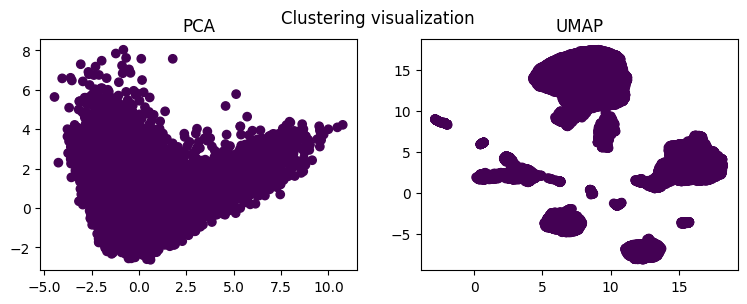

Cluster 0 size: 69826


,Track,Artist
0,H.I.E.L.O.,Duki
1,Confiado & Tranquilo,Paulo Londra
2,Rüyalarda Buruşmuşum,Adamlar
3,Lay It All on Me (feat. Ed Sheeran),Rudimental
4,Regenbogenfarben,Kerstin Ott
5,Problèmes d'adultes,Sexion d'Assaut
6,Je me dis que toi aussi,Boulevard des Airs
7,Nena Maldición (feat. Lenny Tavárez),Paulo Londra
8,Amame,Alexandre Pires
9,Frank Sinatra,Cake


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'latin', 'classic rock', 'latin pop', 'rap', 'mellow gold', 'hip hop', 'post-teen pop']


In [25]:
from sklearn.cluster import KMeans


clustering = KMeans(n_clusters=1, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Wygląda na to, że najpopularniejsze są pop i rock, a najbardziej "typowe" piosenki też należą do takiej grupy. Ogół piosenek ma dość dużą głośność, dużą dynamikę (wysokie time signature - "how many beats are in each bar") i są pozytywne (valence - "tracks with high valence sound more positive"). Zasadniczo jest to zgodne z intuicją. Ciekawe jednak, co będzie, jak wybierzemy więcej klastrów.

**Zadanie 3 (1.5 punktu)**

1. Wytrenuj k-means dla 3 klastrów.
2. Zwizualizuj wyniki za pomocą PCA i UMAP. Jako kolor punktów (np. parametr `c` w `plt.scatter()`) przekaż numery klastrów dla punktów.
3. Dokonaj opisu i analizy wynikowych klastrów, na przykład:
   - czy reprezentują jakieś konkretne grupy muzyczne?
   - na ile "konkretne", sensowne są klastry?
   - czy jest widoczna separacja klastrów, czy różnią się od siebie?
4. Dokonaj tuningu liczby klastrów:
   - sprawdź wartości z zakresu [5, 20] - w końcu wiemy, że gatunków jest sporo, i klastrów powinno też być więcej
   - dla każdej wartości sprawdź wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
   - przedstaw wykres liniowy (line plot) wartości metryki
   - wybierz model o najwyższej wartości metryki
   - zwizualizuj wyniki z pomocą PCA i UMAP
   - dokonaj interpretacji jego klastrów
   - skomentuj:
     - czy klastry są faktycznie lepiej interpretowalne po tuningu?
     - czy wysokość CH-index faktycznie odpowiada jakości klasteryzacji?


Number of clusters: 3
CH-index value: 8674.86


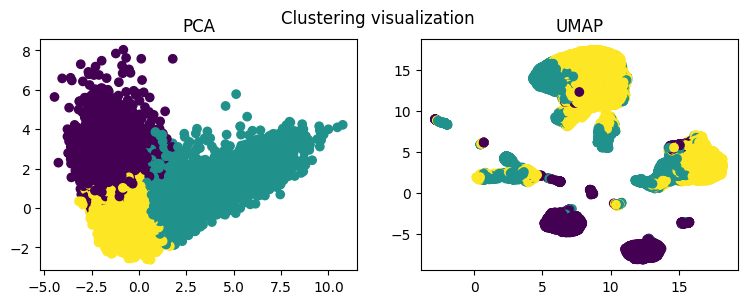

Cluster 0 size: 11764


,Track,Artist
0,Dangerous (feat. YG),The Neighbourhood
1,7 sur 7,Koba LaD
2,Dándole,Arte Elegante
3,Primo,RAF Camora
4,Van Damme,SDM
5,Vertigini,Tedua
6,No Stress,Kekra
7,Zły,Szpaku
8,Le regard des gens,Nekfeu
9,Paper Route,Hooligan Hefs


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop', 'pop urbaine', 'french hip hop', 'southern hip hop', 'dance pop']
Cluster 1 size: 14665


,Track,Artist
0,A fuego - Bizarrap Remix,DrefQuila
1,Stay Alive,José González
2,Ol' 55,Tom Waits
3,Kto powie mi jak,Kwiat Jabłoni
4,Smoke on the Water,The Cooltrane Quartet
5,Raatein,Jasleen Royal
6,Find Yourself,Brad Paisley
7,Basta Ya Mi Amor,Agua Marina
8,Even the Nights Are Better,Air Supply
9,La Danza de las Libélulas (Con Mon Laferte),Manuel García


Top 10 genres in the cluster: ['rock', 'adult standards', 'classic rock', 'pop', 'mellow gold', 'soft rock', 'latin pop', 'album rock', 'folk rock', 'latin']
Cluster 2 size: 43397


,Track,Artist
0,Guerrera,DELLAFUENTE
1,Ojos Así,Shakira
2,Seviyorum Sevmiyorum,Nil Karaibrahimgil
3,Lay It All on Me (feat. Ed Sheeran),Rudimental
4,Meltinpot,Gazzelle
5,Small Town USA,Justin Moore
6,Ni Mandándote A Hacer,Calibre 50
7,Girl At Home,Taylor Swift
8,Suspicious Minds,Fine Young Cannibals
9,Painkiller,Ruel


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'latin', 'latin pop', 'classic rock', 'regional mexican', 'post-teen pop', 'album rock', 'pop rock']


In [26]:
clustering = KMeans(n_clusters=3, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Kształt pierwszego klastra różni się od pozostałych które są podobne. szczególnie odrużnia je cechaexplicit. Pozostałe 2 klastry odróżnia acousticness, ale nie wyglądają jak opis konkretnego gatunku. Może trochę ułatwiło by sprawę użycie zmiennych kategorycznych na mode i key oraz binarney na time signature które przeważnie rozważamy jako 4/4 i nie 4/4. Moje muzyczne zboczenie zawodowe nie da mi spokoju

In [27]:
from sklearn.metrics import calinski_harabasz_score

In [28]:
scores = []

for i in range(5, 20):
    clustering = KMeans(n_clusters=i, n_init="auto", random_state=0)
    clustering.fit(X)
    scores.append(calinski_harabasz_score(X, clustering.labels_))

<Axes: >

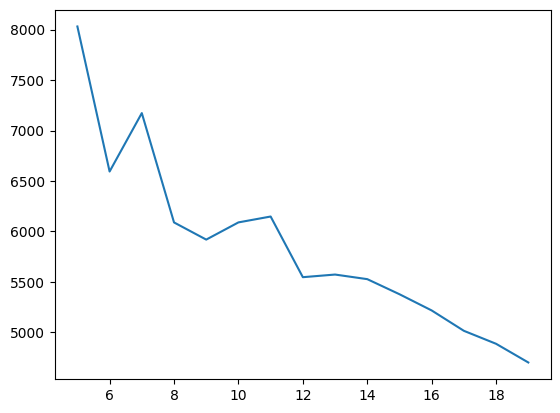

In [29]:
pd.Series(scores, index=np.arange(5, 20)).plot()

Number of clusters: 5
CH-index value: 8031.37


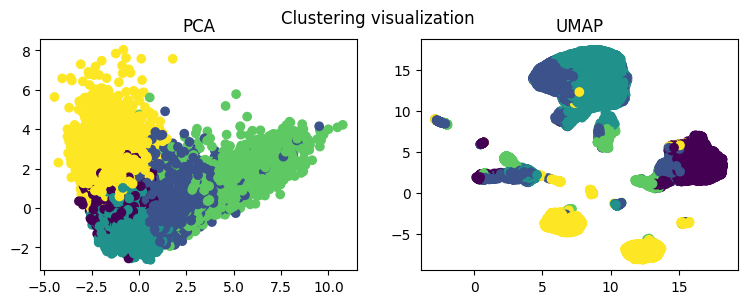

Cluster 0 size: 16716


,Track,Artist
0,Elevator (feat. Timbaland),Flo Rida
1,Туманы,Max Barskih
2,Secret Door,Arctic Monkeys
3,Quién eres tú (feat. Trey Songz),María José
4,Haus am See,Peter Fox
5,Te Necesito,Bhavi
6,Sıfır Tolerans,Hadise
7,Trivia 承 : Love,BTS
8,Real Life,Duke Dumont
9,Comes and Goes 와리가리,HYUKOH


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'latin', 'latin pop', 'tropical', 'trap latino', 'post-teen pop', 'classic rock', 'rock en espanol']
Cluster 1 size: 12573


,Track,Artist
0,Chachachá,Jósean Log
1,Ol' 55,Tom Waits
2,Aaftaab,The Local Train
3,Agárrate a mí María (feat. Antonio Vega),Los Secretos
4,How Deep Is Your Love,Take That
5,Even the Nights Are Better,Air Supply
6,Isn't It Romantic,Rod Stewart
7,Evidencias,Ana Gabriel
8,Ebrio De Amor,Ezequiel Peña
9,Fortunate Fool,Jack Johnson


Top 10 genres in the cluster: ['rock', 'adult standards', 'pop', 'mellow gold', 'classic rock', 'soft rock', 'latin pop', 'latin', 'folk rock', 'ranchera']
Cluster 2 size: 26072


,Track,Artist
0,Guerrera,DELLAFUENTE
1,Ojos Así,Shakira
2,Meltinpot,Gazzelle
3,Small Town USA,Justin Moore
4,Ni Mandándote A Hacer,Calibre 50
5,Bagatelle,Pinguini Tattici Nucleari
6,Painkiller,Ruel
7,Lay It All on Me (feat. Ed Sheeran),Rudimental
8,Podría Ser Peor,La Casa Azul
9,Girl At Home,Taylor Swift


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'dance pop', 'regional mexican', 'classic rock', 'latin pop', 'pop rock', 'album rock', 'mellow gold']
Cluster 3 size: 3177


,Track,Artist
0,Beyond the Sea,Richard Clayderman
1,Burn One Down,Ben Harper
2,Kid A,Radiohead
3,How Deep Is Your Love,Richard Clayderman
4,Exchange,Massive Attack
5,Tender love,Mounika.
6,Heimta Thurs,Wardruna
7,With Or Without You,2CELLOS
8,The Great Gig in the Sky,Pink Floyd
9,The Great Gig In The Sky - 2011 Remastered Ver...,Pink Floyd


Top 10 genres in the cluster: ['rock', 'soundtrack', 'classical', 'alternative rock', 'art rock', 'electronica', 'classic rock', 'album rock', 'permanent wave', 'alternative metal']
Cluster 4 size: 11288


,Track,Artist
0,Dangerous (feat. YG),The Neighbourhood
1,Dándole,Arte Elegante
2,Primo,RAF Camora
3,7 sur 7,Koba LaD
4,Vertigini,Tedua
5,Broken Clocks,SZA
6,Le regard des gens,Nekfeu
7,Zły,Szpaku
8,Van Damme,SDM
9,Paper Route,Hooligan Hefs


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop urbaine', 'french hip hop', 'pop', 'southern hip hop', 'dance pop']


In [30]:
clustering = KMeans(n_clusters=5, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

1. klaster wygląda na pop i domieszkę latino pop. wysoka doza acousticness może też wskazywać na indie
2. starsza, klasyka popu
3. pop, dance music, radiopop
4. rock, kalsycczny rock, alternatywa, chyba najambitniejszy klaster. radiohet w topce haha
5. hip hop

mniej więcej pasuje to do odnalezionych kategorii gatunków chociaż mogłoby być lepiej


Problem z k-means jest taki, że wykrywa tylko klastry sferyczne. W przypadku zbiorów, w których klastry mogą być mocno wymieszane, będzie to szczególnym problemem. Tak może być tutaj - w końcu mamy co najmniej kilka podgatunków rocka i popu, które są zbliżone do siebie. Mamy też dość egzotyczne podgatunki takie jak "art rock" czy "rock en espanol", które być może są nieliczne i stanowią de facto szum.

Do takich sytuacji doskonale nadaje się DBSCAN. Ma co prawda większą złożoność, ale dla danych tego rozmiaru jest to jeszcze akceptowalne. Sprawdźmy, jak działa dla domyślnych hiperparametrów - epsilon 0.5 i min_samples 5.

Number of clusters: 244
Percentage of noise points: 93.66%
CH-index value: 33.98


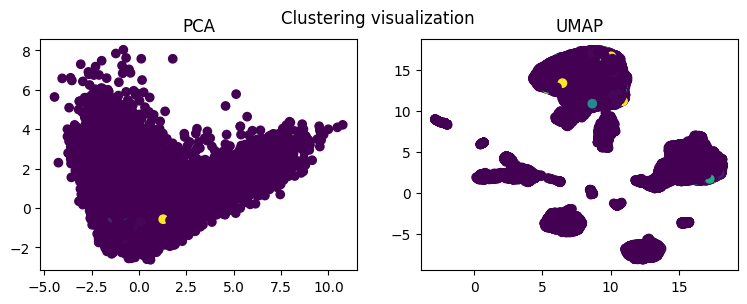

Cluster 3 size: 2290


,Track,Artist
0,Love Today,MIKA
1,"The Karma Theme - Telugu (From ""U Turn"")",Anirudh Ravichander
2,Mirala Miralo,Alejandra Guzman
3,"Mírala, Míralo - En Vivo",Alejandra Guzman
4,CROWN,TOMORROW X TOGETHER
5,Baila Morena - New Spanish Version,Zucchero
6,Walau Habis Terang,Noah
7,No Such Thing,John Mayer
8,Bailarina,Maldita Nerea
9,New Romantics,Taylor Swift


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop rock', 'latin', 'latin pop', 'modern rock', 'alternative metal', 'rock en espanol']


In [31]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Mamy niesamowicie dużo klastrów oraz szumu - niedobrze! Oznacza to, że zbyt ciężko jest "dotrzeć" do kolejnych punktów, żeby stworzyć klastry. Mogą być tego dwie przyczyny:
- zbyt mały promień epsilon
- zbyt duże min_samples

Biorąc pod uwagę, że minimalna liczba próbek to zaledwie 5, to to drugie nie występuje. Musimy zatem zwiększyć promień. Ale jak, skoro nie znamy jednostek?

Dobór hiperparametrów w DBSCAN dobrze opisuje [ten post](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), który zgadza się zresztą z "Data Clustering" Charu C. Aggarwala.

Wartość min_samples można przyjąć z grubsza (rule-of-thumb) jako liczbę wymiarów razy 2. Bierze to poprawkę na rzadkość przestrzeni, i generalnie jest dobrą wartością wyjściową. Jeżeli mamy dużo szumu, to można próbować więcej.

Przy stałym min_samples heurystyka do wyboru epsilon wygląda następująco. Obliczamy rozkład odległości do k najbliższych sąsiadów, przyjmując k = min_samples, a następnie przedstawiamy to na wykresie. Typowo będzie miał kształt z grubsza zbliżony do litery L (lub odwróconego L), i dobra wartość epsilon jest na punkcie przegięcia tego wykresu, tzw. elbow / knee.

**Zadanie 4 (1.5 punktu)**

Stwórz wykres odległości do najbliższych sąsiadów, przyjmując liczbę najbliższych sąsiadów równą 2 razy liczba cech. Może się przydać [ten tutorial](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd).

Odczytaj z wykresu wartość punktu przegięcia. Czy jest to łatwe? Czy jesteś w stanie ją wyznaczyć dokładnie?

In [32]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [58]:
neighbors = NearestNeighbors(n_neighbors=X.shape[1] * 2)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

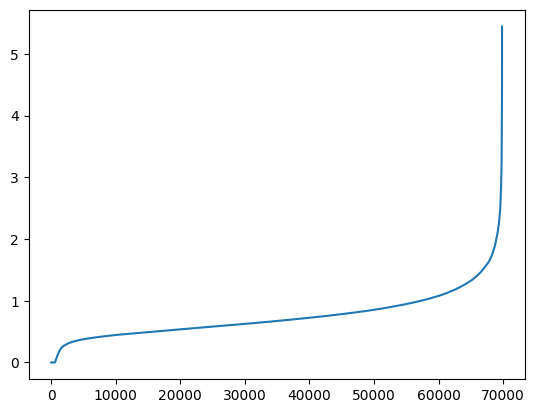

In [59]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

Numeryczne obliczanie pochodnej by wyznaczyć punkt przegięcia nie daje dobrych rezultatów bo istnieją punkty sąsiadujące o tej samej wartości dla których pochodna przyjmuje wartość 0 co nie pozwala na sensowne obliczenia. Ale na oko jest gdzieś bliżej 1 niż 0. więc strzlmy 0.7

Taka heurystyczna metoda jest wykorzystywana w wielu przypadkach doboru hiperparametrów w klasteryzacji. Zasadnicza idea jest taka, że punkt przegięcia odpowiada momentowi, gdzie dane zaczynają wyraźnie rozróżniać się od siebie i tworzyć wyraźne grupy. Jest to proste i szybkie, ale jest dość nieprecyzyjne w porównaniu do innych metod (jeżeli w ogóle istnieją dla danego zadania!). Jeżeli chcemy zrobić walidację skrośną, korzystając z jakiejś metryki, to taki wykres daje nam sensowny punkt wyjścia do zakresu hiperparametru.

Warto też pamiętać, że klasteryzacja to proces z natury interaktywny. Takie wykresy są ważne, bo zwiększają naszą intuicję, ale np. dokładne dobranie wartości jest typowo robione ręcznie.

**Zadanie 5 (1.5 punktu)**

Wytrenuj DBSCAN z promieniem epsilon wyznaczonym z wykresu i min_samples równym 2 razy liczbie cech. W razie potrzeby zmniejsz lub zwiększ epsilon, aby uzyskać wyniki, które wydają się sensowne (liczba klastrów, procent szumu, CH-index).

Dokonaj analizy wyjściowych klastrów. Czy finalna ich liczba oraz procent szumu są sensowne? Czy klastry są lepiej widoczne, lub lepiej interpretowalne, niż w przypadku k-means?

Number of clusters: 6
Percentage of noise points: 88.39%
CH-index value: 500.13


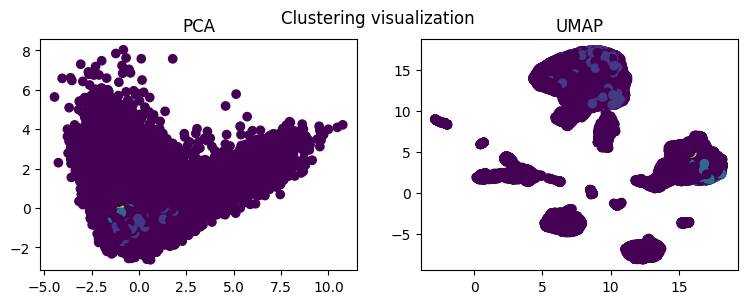

Cluster 0 size: 6494


,Track,Artist
0,Ni Mandándote A Hacer,Calibre 50
1,"Gone, Gone, Gone",Phillip Phillips
2,Fallin' For You,Colbie Caillat
3,Regenbogenfarben,Kerstin Ott
4,Morir Tres Veces,Mœnia
5,Lay It On Me,Vance Joy
6,Love Today,MIKA
7,CROWN,TOMORROW X TOGETHER
8,Mirala Miralo,Alejandra Guzman
9,"The Karma Theme - Telugu (From ""U Turn"")",Anirudh Ravichander


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'latin', 'post-teen pop', 'latin pop', 'pop rock', 'modern rock', 'rock en espanol', 'contemporary country']
Cluster 1 size: 1334


,Track,Artist
0,Ocean Drive,Duke Dumont
1,Каждый раз,Monetochka
2,Join Me - Razorblade Mix,HIM
3,Can't Feel My Face,The Weeknd
4,Real Life,Duke Dumont
5,Cámara De Faltas,Enjambre
6,Ravotten - Original Mix,Mr. Polska
7,Me Liberé,Evaluna Montaner
8,Comes and Goes 와리가리,HYUKOH
9,OK,Robin Schulz


Top 10 genres in the cluster: ['dance pop', 'pop', 'latin', 'post-teen pop', 'rock', 'latin pop', 'pop dance', 'edm', 'tropical house', 'modern rock']
Cluster 4 size: 204


,Track,Artist
0,7 Things - Single Version,Miley Cyrus
1,7 Things,Miley Cyrus
2,Disfruto - Audioiko Remix,Carla Morrison
3,Want to Want Me,Jason Derulo
4,Little Bit of Love,Tom Grennan
5,Cemetery Drive,My Chemical Romance
6,Why Worry,Set It Off
7,Straight Through My Heart,Backstreet Boys
8,Giant (with Rag'n'Bone Man),Calvin Harris
9,Cuando zarpa el amor,Camela


Top 10 genres in the cluster: ['dance pop', 'pop', 'post-teen pop', 'latin', 'rock', 'pop rock', 'alternative metal', 'latin pop', 'pop dance', 'modern rock']


In [70]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.7, min_samples=X.shape[1] * 2, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Z jakiś powodów klastry wyglądają identycznie. nie uzyskujemy dobrych wyników ani dla mniejszych ani większych promieni


DBSCAN ma dwie zasadnicze wady: trudny dobór hiperparametrów oraz podatność na szum. W szczególności to drugie widać, jeżeli w naszym zbiorze ciągle znajduje on dużo szumu - to oznaka, że mamy zmienną gęstość w danych i przydałoby się coś adaptacyjnego, jak OPTICS albo HDBSCAN. OPTICS jest bardziej zoptymalizowany pod pamięć niż szybkość w scikit-learn, plus ma raczej nieintuicyjne hiperparametry (może nawet bardziej, niż DBSCAN), więc wykorzystamy tutaj HDBSCAN.

Jego głównym hiperparametrem jest `min_cluster_size`, czyli po prostu minimalna liczba punktów, aby stworzyć klaster. Dodatkowo `min_samples` ma takie samo znaczenie, jak w DBSCAN, czyli jest to minimalna liczba punktów, aby utworzyć punkt typu CORE. Domyślnie są one równe, ale oczywiście można ustawić `min_samples` (sporo) mniejsze od `min_cluster_size`, i dostrajać oba.

Co ważne, HDBSCAN potrafi cache'ować wyniki obliczeń dla stałego `min_samples`, dlatego warto je czasem ustawiać choćby tylko z tego powodu. Caching wymaga też podania argumentu `memory`. Przyspiesza to drugie i kolejne wykonania algorytmu o rzędy wielkości.

Number of clusters: 19
Percentage of noise points: 3.05%
CH-index value: 1656.73


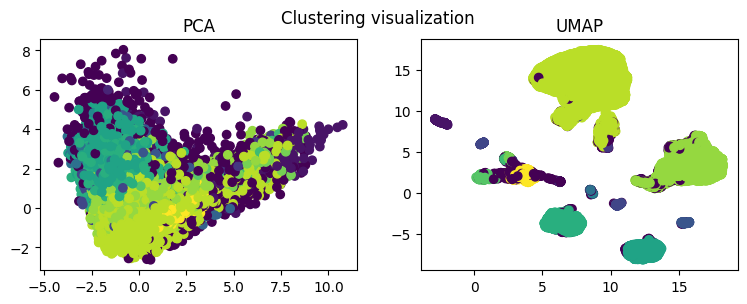

Cluster 16 size: 34355


,Track,Artist
0,Ojalá Te Animes,Bobby Pulido
1,La Rosa,Bobby Pulido
2,Simple Kind Of Life,No Doubt
3,You Learn - 2015 Remaster,Alanis Morissette
4,Vive,Bobby Pulido
5,Moving,Supergrass
6,Pumping On Your Stereo,Supergrass
7,Hand in My Pocket - 2015 Remaster,Alanis Morissette
8,Head over Feet - 2015 Remaster,Alanis Morissette
9,blind,ROLE MODEL


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'classic rock', 'dance pop', 'latin pop', 'mellow gold', 'soft rock', 'album rock', 'pop rock']
Cluster 15 size: 18405


,Track,Artist
0,Lux Aeterna,Clint Mansell
1,You & I,Avant
2,La Habitación (feat. Manuel Carrasco),Niña Pastori
3,Too Lost In You,Sugababes
4,Válgame Dios,Niña Pastori
5,開始懂了,Stefanie Sun
6,About You Now - Radio Edit,Sugababes
7,Hole In The Head,Sugababes
8,About You Now,Sugababes
9,Tujhe Bhula Diya,Mohit Chauhan


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'latin', 'latin pop', 'tropical', 'classic rock', 'trap latino', 'post-teen pop', 'desi pop']
Cluster 11 size: 5308


,Track,Artist
0,Flossin' (feat. Big Moe),Mike Jones
1,Scream Aim Fire,Bullet For My Valentine
2,onoffonoff,keshi
3,Canela,Nanpa Básico
4,Juicy (feat. Static Major),Pretty Ricky
5,Los No Tan Tristes,Nanpa Básico
6,Embriagá,Bryant Myers
7,Weekend,Louis The Child
8,Back Then,Mike Jones
9,UCLA,RL Grime


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop', 'southern hip hop', 'dance pop', 'pop urbaine', 'french hip hop']
Cluster 10 size: 4945


,Track,Artist
0,Working For It,ZHU
1,Hit 'Em High,B-Real
2,Shea Butter Baby (with J. Cole),Ari Lennox
3,Drank & Drugs,Lil Kleine
4,Niet Omdat Het Moet,Lil Kleine
5,Alleen,Lil Kleine
6,Stripclub,Lil Kleine
7,Dichterbij Je,Lil Kleine
8,Stoff und Schnaps,Lil Kleine
9,Beverly Hills,Ufo361


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop urbaine', 'french hip hop', 'gangster rap', 'trap', 'pop', 'southern hip hop', 'rap francais']
Cluster 18 size: 2229


,Track,Artist
0,Nenjukkule,A.R. Rahman
1,¿Por Que Me Enamoré?,Ulices Chaidez
2,Sei Lá,Projota
3,Als Alle Lichten Zijn Gedoofd,Marco Borsato
4,"Girl Crush - Recorded at Metropolis Studios, L...",Harry Styles
5,Por Enamorarme,Los Plebes del Rancho de Ariel Camacho
6,Iván Archivaldo,Virlan Garcia
7,A Lo Que Voy,Virlan Garcia
8,Según Tus Labios,Los Plebes del Rancho de Ariel Camacho
9,La Princesa,La Adictiva Banda San José de Mesillas


Top 10 genres in the cluster: ['regional mexican', 'corrido', 'nuevo regional mexicano', 'ranchera', 'norteno', 'banda', 'rock', 'adult standards', 'pop', 'latin pop']
Cluster 13 size: 842


,Track,Artist
0,Oceans,Seafret
1,Friends,Chase Atlantic
2,Lie,BTS
3,Fever To The Form,Nick Mulvey
4,Arsonist's Lullabye,Hozier
5,"Janam Janam (From ""Dilwale"")",Arijit Singh
6,Yaad Hai Na,Arijit Singh
7,Naan Un,Arijit Singh
8,Janam Janam,Arijit Singh
9,Celestica,Crystal Castles


Top 10 genres in the cluster: ['rock', 'pop', 'regional mexican', 'corrido', 'nuevo regional mexicano', 'filmi', 'adult standards', 'classic rock', 'sierreno', 'dance pop']
Cluster 3 size: 468


,Track,Artist
0,Un Hombre Normal,Espinoza Paz
1,oui,Jeremih
2,Nada Normal,Victor & Leo
3,When Your Mind's Made Up,Glen Hansard
4,Per uno come me,Negramaro
5,End of the Day,One Direction
6,十萬毫升淚水,Tanya Chua
7,She's Like A Star,Taio Cruz
8,Wine Slow,Gyptian
9,Byahe,John Roa


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'turkish pop', 'desi pop', 'post-teen pop', 'adult standards', 'modern bollywood', 'latin', 'r&b']
Cluster 0 size: 378


,Track,Artist
0,Las Heladas,Los Tucanes De Tijuana
1,Shawshank Prison - Stoic Theme,Thomas Newman
2,Underwood,Ludovico Einaudi
3,Je T’aime,Lara Fabian
4,Burning,Ludovico Einaudi
5,Road To Perdition,Thomas Newman
6,Careful What You Wish For,Eminem
7,One Fine Day - Remastered,Natalie Merchant
8,I Am You,Nightmares On Wax
9,Tatuaże z henny,Guzior


Top 10 genres in the cluster: ['regional mexican', 'corrido', 'nuevo regional mexicano', 'rock', 'norteno', 'sleep', 'rap', 'adult standards', 'ranchera', 'classic rock']
Cluster 4 size: 291


,Track,Artist
0,I Want It,Juice WRLD
1,Soy Mencho,Lenin Ramírez
2,Verdes Verdes,Natanael Cano
3,Miami Vibe,Adriel Favela
4,PILL BREAKER (feat. blackbear & Machine Gun Ke...,Trippie Redd
5,Miss You,Louis Tomlinson
6,Scars,Brennan Savage
7,All Your Exes,Julia Michaels
8,The Bigger Picture,Lil Baby
9,.357,HAVAL


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop urbaine', 'french hip hop', 'pop', 'nuevo regional mexicano', 'pop rap', 'corrido', 'regional mexican', 'corridos tumbados']
Cluster 14 size: 162


,Track,Artist
0,When You Wish Upon A Star,Stan Whitmire
1,Neville's Waltz,Patrick Doyle
2,Jessica's Theme From The Man From Snowy River,Stan Whitmire
3,Nemo Egg (Main Title),Thomas Newman
4,Buckbeak's Flight,John Williams
5,Theme From Jurassic Park,John Williams
6,Porz Goret,Yann Tiersen
7,"Theme - From ""Emma""",Rachel Portman
8,Main Titles,Rachel Portman
9,Rose,James Horner


Top 10 genres in the cluster: ['soundtrack', 'classical', 'compositional ambient', 'sleep', 'post-romantic era', 'adult standards', 'scorecore', 'lullaby', 'middle earth', 'neo-classical']


In [71]:
from hdbscan import HDBSCAN


clustering = HDBSCAN(memory="tmp")
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Domyślne `min_cluster_size` to zaledwie 5, a mimo tego HDBSCAN wcale nie znalazł tak dużo klastrów - pokazuje to jego zdolność do adaptacji do zbioru danych. CH-index nie jest zbyt wysoki, pomimo tego, że niektóre klastry wydają się ciekawe i inne niż w k-means. Pokazuje to też, że klastry pewnie nie są sferyczne.

**Zadanie 6 (2 punkty)**

Dokonaj ręcznego tuningu hiperparametrów `min_cluster_size` oraz `min_samples`. Pamiętaj, że przy stałym `min_samples` możesz praktycznie za darmo zmieniać `min_cluster_size` dzięki cache'owaniu.

Skomentuj finalne wyniki. Czy udało się uzyskać sensowne, interpretowalne klastry? Czy są one w jakimś stopniu nieoczywiste, tj. czy otrzymaliśmy jakąś nową wiedzę dzięki klasteryzacji? Czy CH-index wskazał sensownie na jakość klasteryzacji w HDBSCAN?

In [81]:
best_score = 0
best_clustering = None

for size in range(3, 20):
    for samples in [None] + list(range(20, 30)):
        clustering = HDBSCAN(min_cluster_size=size, min_samples=samples, memory="tmp")
        clustering.fit(X)
        score = calinski_harabasz_score(X, clustering.labels_)
        if score > best_score:
            best_score = score
            best_samples = samples
            best_size = size

In [82]:
best_size, best_samples

(18, None)

Number of clusters: 12
Percentage of noise points: 9.32%
CH-index value: 2987.17


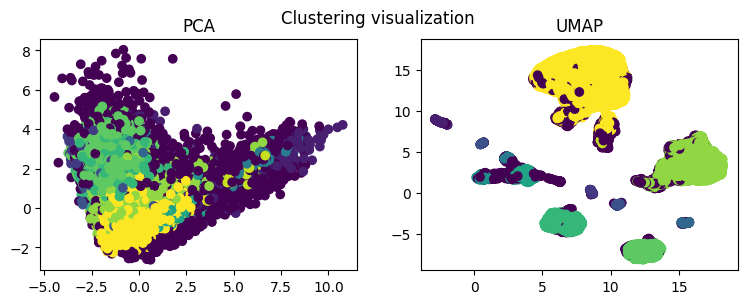

Cluster 11 size: 31180


,Track,Artist
0,Todo Sigue Igual,Viejas Locas
1,公私混同,Yuzu
2,Better Days,The Goo Goo Dolls
3,King of the World,First Aid Kit
4,Barricades,Hiroyuki Sawano
5,Everything About You,One Direction
6,Illusion,One Direction
7,The Dirt Whispered,Rise Against
8,Bide Your Time,Courteeners
9,Call On Me - Ryan Riback Remix,Starley


Top 10 genres in the cluster: ['rock', 'pop', 'latin', 'dance pop', 'latin pop', 'classic rock', 'mellow gold', 'soft rock', 'pop rock', 'regional mexican']
Cluster 9 size: 17826


,Track,Artist
0,Évidemment,Trois Cafés Gourmands
1,Beggin (original version),Madcon
2,Beggin',Madcon
3,Ni Una Sola Palabra,Paulina Rubio
4,Girl's Not Grey,AFI
5,Sweet Melody,Little Mix
6,Welcome to My Crib,Randy
7,FutureSex / LoveSound,Justin Timberlake
8,D'or et de platine,Gradur
9,Like An Animal,RÜFÜS DU SOL


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'latin', 'latin pop', 'tropical', 'classic rock', 'trap latino', 'post-teen pop', 'desi pop']
Cluster 7 size: 5063


,Track,Artist
0,Who Mad Again,Jahyanai
1,ROSE MARTHE'S LOVE,Damso
2,Salam,Boef
3,Boasty (feat. Idris Elba),Wiley
4,H&M,Niska
5,Θ. Macarena,Damso
6,Break Stuff,Limp Bizkit
7,Dangerous,RK
8,W.L.G,Niska
9,God is a woman,Ariana Grande


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'pop', 'southern hip hop', 'dance pop', 'pop urbaine', 'french hip hop']
Cluster 8 size: 4755


,Track,Artist
0,Playa Hater - 2014 Remaster,The Notorious B.I.G.
1,Yemin Olsun,Ufo361
2,Sexy Bitch (feat. Akon),David Guetta
3,Hennessy,Zomb
4,Into It,Chase Atlantic
5,Дядя Володя,Pornofilmy
6,motive (with Doja Cat),Ariana Grande
7,T-shirt croco,Naps
8,J'ai pas dormi de la nuit,Djadja & Dinaz
9,Good Weed Bad B*tch,K CAMP


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop urbaine', 'french hip hop', 'gangster rap', 'trap', 'pop', 'rap francais', 'southern hip hop']
Cluster 6 size: 2320


,Track,Artist
0,Iniciales AL (Porte Fino),Natanael Cano
1,¿Dónde Estabas Tú?,Danna Paola
2,Juro Por Esta,Christian Nodal
3,Hombre Libre,La Adictiva Banda San José de Mesillas
4,Te Hubieras Ido Antes,Ricardo Montaner
5,Me Gustas Mucho,Código FN
6,Welcome to Wonderland,Anson Seabra
7,Vengo a Aclarar,El Fantasma
8,Body and Soul,Tony Bennett
9,I Was Here,Beyoncé


Top 10 genres in the cluster: ['regional mexican', 'corrido', 'nuevo regional mexicano', 'ranchera', 'norteno', 'banda', 'rock', 'adult standards', 'pop', 'latin pop']
Cluster 5 size: 714


,Track,Artist
0,La Inmensidad,La Maravillosa Orquesta del Alcohol
1,誓い,Hikaru Utada
2,fake optics,Ardhito Pramono
3,Nillayo,Haricharan
4,Un Poco Más De Frío,Cami
5,Poi Vazhva,Santhosh Narayanan
6,Feeling Good,Muse
7,The Difference Between Medicine And Poison Is ...,Circa Survive
8,Heart Upon My Sleeve (feat. Imagine Dragons),Avicii
9,Is This Love,Corinne Bailey Rae


Top 10 genres in the cluster: ['rock', 'pop', 'regional mexican', 'corrido', 'filmi', 'nuevo regional mexicano', 'adult standards', 'sierreno', 'dance pop', 'classic rock']
Cluster 2 size: 413


,Track,Artist
0,Si te pienso,DrefQuila
1,Un Hombre Normal,Espinoza Paz
2,Comme toi,Tayc
3,Nada Normal,Victor & Leo
4,Carry Out (Featuring Justin Timberlake),Timbaland
5,十萬毫升淚水,Tanya Chua
6,Per uno come me,Negramaro
7,oui,Jeremih
8,Rivers,SIX60
9,All of Me,Billie Holiday


Top 10 genres in the cluster: ['pop', 'dance pop', 'turkish pop', 'rock', 'post-teen pop', 'desi pop', 'modern bollywood', 'latin', 'adult standards', 'r&b']
Cluster 0 size: 369


,Track,Artist
0,Someone To Watch Over Me,Ella Fitzgerald
1,Hasta Que Salga El Sol,Banda Los Recoditos
2,La Corita,Grupo Laberinto
3,La Cheyene del Año,Banda El Recodo
4,Mingo,Edicion Especial
5,Malditas Ganas,El Komander
6,Las Heladas,Los Tucanes De Tijuana
7,Mi Porvenir,Alfredo Olivas
8,La Escuadra (En Que Trabaja El Muchacho),Los Huracanes del Norte
9,Saaiyaan,Salim–Sulaiman


Top 10 genres in the cluster: ['regional mexican', 'corrido', 'nuevo regional mexicano', 'rock', 'norteno', 'sleep', 'adult standards', 'ranchera', 'rap', 'classic rock']
Cluster 3 size: 216


,Track,Artist
0,Con Tus Besos,Eslabon Armado
1,El Problema,Cornelio Vega y su Dinastia
2,Atrapado en un Sueño,Junior H
3,Ville Mentality,J. Cole
4,Vengo De Nada,Ovi
5,Fuck You Bitch,Wheeler Walker Jr.
6,On It,Jazmine Sullivan
7,Monde,Damso
8,I Think I'm In Love,Kat Dahlia
9,Mente Positiva,Junior H


Top 10 genres in the cluster: ['rap', 'nuevo regional mexicano', 'corridos tumbados', 'pop urbaine', 'hip hop', 'corrido', 'french hip hop', 'regional mexican', 'pop', 'pop rap']
Cluster 1 size: 192


,Track,Artist
0,Zoo York (feat. Fivio Foreign & Pop Smoke),Lil Tjay
1,Just Like Me (feat. Young Thug),A Boogie Wit da Hoodie
2,Kleine Jongen,Lil Kleine
3,Millions d'euros,Landy
4,Lamborghini,KSI
5,Track Star,Mooski
6,Can’t Play Us,Frenna
7,Come Into My Room,Mavado
8,Je Wanda,Dinos
9,Fisherman (feat. MoStack & MIST),J Hus


Top 10 genres in the cluster: ['pop rap', 'rap', 'hip hop', 'trap', 'pop urbaine', 'gangster rap', 'southern hip hop', 'german hip hop', 'french hip hop', 'rap francais']


In [85]:
clustering = HDBSCAN(min_cluster_size=best_size, min_samples=best_samples, memory="tmp")
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Jesteśmy w stanie zobaczyć dużo lepsze klastry. I tak wyglądają dosyć chaotycznie. W końcu udało się wykryć mocny klaster muzyki instrumentalnej

## Zadanie dodatkowe (3 punkty)

Klasteryzacja hierarchiczna jest przydatnym narzędziem, dającym od razu znaczną ilość informacji co do klasteryzacji, ale ze względu na złożoność nadaje się tylko do mniejszych zbiorów danych. Takim zbiorem jest dobrze nam już znany [Ames housing](https://www.openintro.org/book/statdata/?data=ames).

1. Załaduj zbiór i dokonaj odpowiedniego preprocessingu. Zwizualizuj go z pomocą PCA oraz UMAP.
2. Zastosuj klasteryzację hierarchiczną do tego zbioru, wykorzystując metrykę euklidesową i Ward linkage.
3. Narysuj dendrogram dla wynikowej klasteryzacji. Czy widać jakąś strukturę klastrującą? Sprawdź kilka przykładowych próbek, które wydają się podobne - czy faktycznie te domy są podobne?
4. Wybierz klasteryzację, która wydaje się najbardziej stabilna, tj. ma najdłuższe pionowe linie na dendrogramie. Sprawdź jej CH-index, oraz zwizualizuj ją za pomocą PCA oraz UMAP. Ile ma ona klastrów? Czy wydaje się ona sensowna? Wypisz przykładowe domy z klastrów. Czy faktycznie wskazują na zróżnicowanie klastrów?
5. Porównaj tę klasteryzację z k-means (dokonaj tuningu liczby klastrów z pomocą CH-index) oraz HDBSCAN. Ile klastrów wybrały te metody? Czy na wizualizacji PCA i UMAP dają lepsze, czy gorsze wyniki od klasteryzacji hierarchicznej?